In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
#from src.training.train import train_model, train_cellfate
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.layers import Lambda, Input, GaussianNoise,concatenate, Dense, Dropout, Conv2D, Add, UpSampling2D, Dot, Conv2DTranspose, Activation, Reshape, InputSpec, LeakyReLU, Flatten, BatchNormalization, SpectralNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf
from keras.models import load_model
from keras.applications import VGG19, VGG16
from keras.activations import swish
from keras.initializers import glorot_uniform, glorot_normal, GlorotUniform
from keras.constraints import max_norm, UnitNorm
from ipywidgets import interact, IntSlider
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
# x_train = np.load('../data/stretched_x_train.npy')
# x_test = np.load('../data/stretched_x_test.npy')
x_train = np.load('../data/centered_x_train.npy')
y_train = np.load('../data/train_labels.npy')
x_test = np.load('../data/centered_x_test.npy')
y_test = np.load('../data/test_labels.npy')

# Full cell fate

In [4]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

num_classes = len(np.unique(y_train))
# Build a new model for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to flatten feature maps
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Final model
clf_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze VGG19 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

tf.keras.utils.set_random_seed(812)

clf_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), metrics=["accuracy"])

clf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5093 - loss: 0.7432 - val_accuracy: 0.6377 - val_loss: 0.6469
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5950 - loss: 0.6773 - val_accuracy: 0.6884 - val_loss: 0.6123
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6154 - loss: 0.6649 - val_accuracy: 0.6522 - val_loss: 0.6361
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6389 - loss: 0.6513 - val_accuracy: 0.6449 - val_loss: 0.6264
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6405 - loss: 0.6390 - val_accuracy: 0.6449 - val_loss: 0.6193
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6525 - loss: 0.6235 - val_accuracy: 0.6377 - val_loss: 0.6249
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6451 - loss: 0.6203 - val_accuracy: 0.6304 - val_loss: 0.6263
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6625 - loss: 0.6099 - val_accuracy: 0.

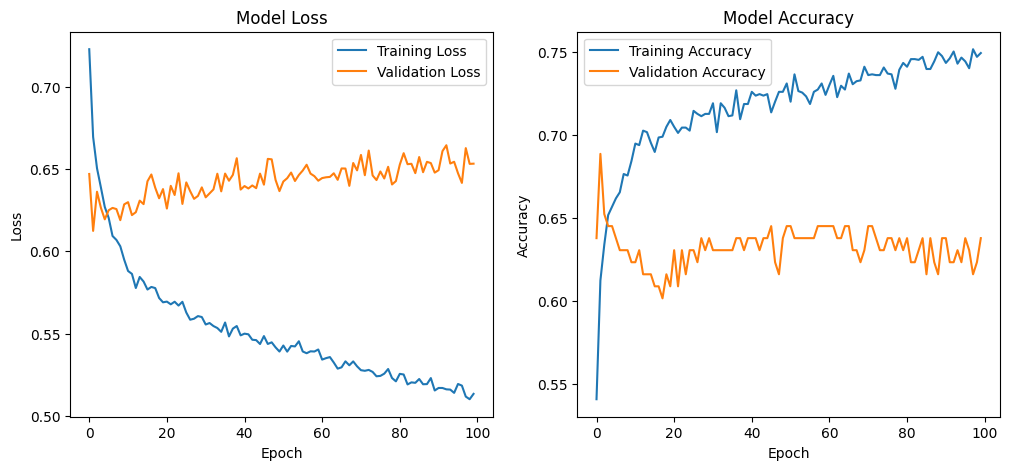

In [5]:
def process_for_vgg(image): # the input is (20, 20)
    # Pad to make it the minimum size for VGG (32, 32, 3)
    image = np.expand_dims(image, axis=-1)
    padded_x_train = np.pad(image, ((0, 0), (6, 6), (6, 6), (0, 0)), mode='constant')
    padded_x_train = np.concatenate((padded_x_train, padded_x_train), axis=-1)
    padded_x_train = np.concatenate((padded_x_train, padded_x_train[:,:,:,0:1]), axis=-1)
    return padded_x_train

x_val, x_test_, y_val, y_test_ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

history = clf_model.fit(process_for_vgg(x_train), y_train, batch_size=32, epochs=100, validation_data=(process_for_vgg(x_val), y_val))

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.62162162 0.37837838]
 [0.32142857 0.67857143]]


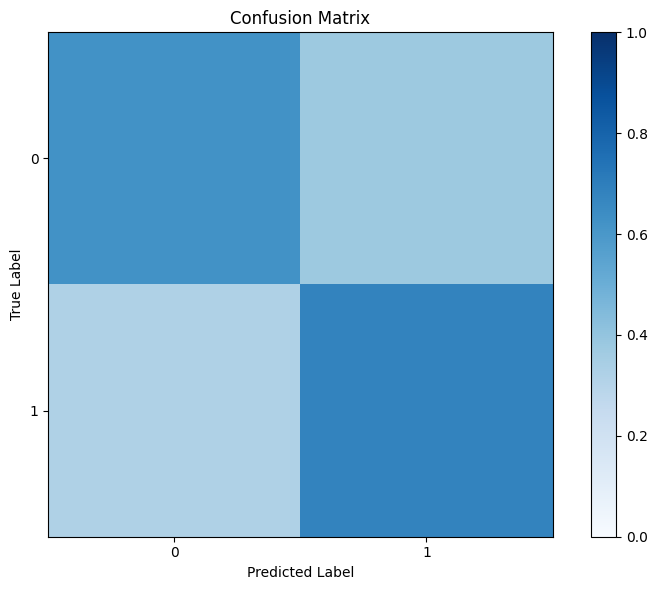

In [6]:
num_classes = len(np.unique(y_train))
y_pred = clf_model.predict(process_for_vgg(x_test_))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Getting pretrained full model without classifier

In [ ]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 0,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decoder.weights.h5")

# encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/encoder.weights.h5")
# decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/decoder.weights.h5")
# discriminator.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/discriminator.weights.h5")


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
encoder.predict(x_test).shape

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(277, 2)

In [11]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim']) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.5150 - val_accuracy: 0.6522 - val_loss: 0.6154
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7995 - loss: 0.4923 - val_accuracy: 0.6594 - val_loss: 0.6206
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8293 - loss: 0.4741 - val_accuracy: 0.6594 - val_loss: 0.6232
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.8338 - loss: 0.4590 - val_accuracy: 0.6667 - val_loss: 0.6247
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.8402 - loss: 0.4463 - val_accuracy: 0.6667 - val_loss: 0.6260
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.8467 - loss: 0.4355 - val_accuracy: 0.6667 - val_loss: 0.6275
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.8508 - loss: 0.4264 - val_accuracy: 0.6739 - val_loss: 0.6295
Epoch 8/50
73/73 ━━━━━━━━━━━━━

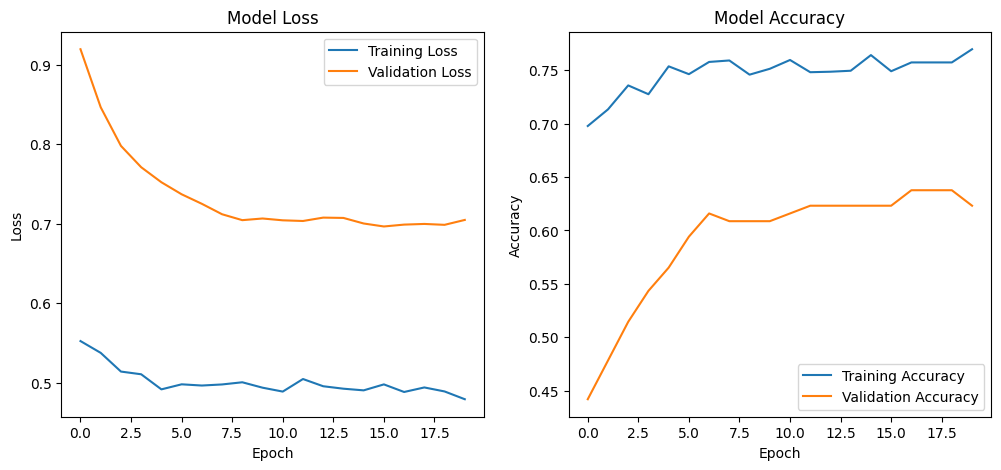

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.68468468 0.31531532]
 [0.25       0.75      ]]


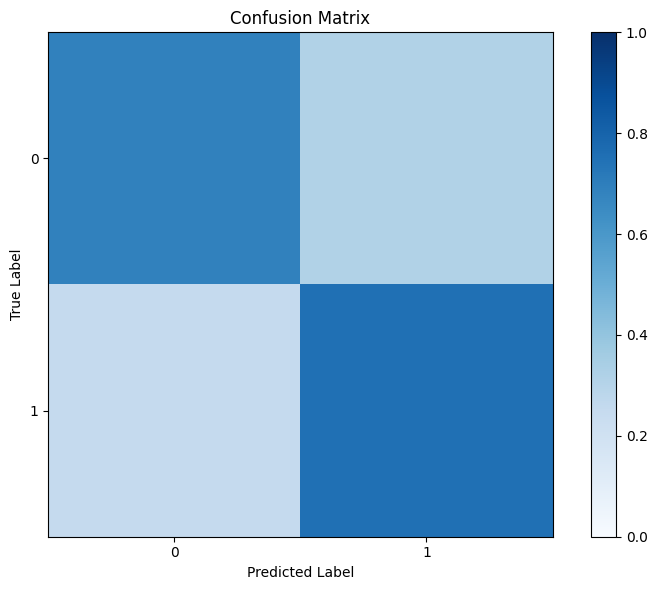

In [12]:
#### LAMBDA CONTRASTIVE LOSS = 4

num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.57657658 0.42342342]
 [0.17857143 0.82142857]]


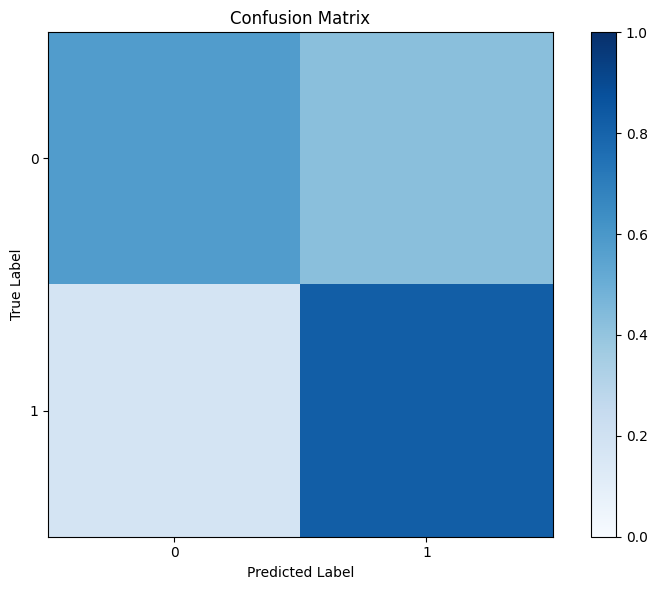

In [8]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [31]:
images_x_test = decoder.predict(x_test_)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [13]:
def visualize_latent_space(latent_space, y_train):
    """Visualize latent space features and their correlation with labels."""
    cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
    cor_vals = np.array(cor_vals)
    feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]  # Find top 2 correlated features

    print(f"Top correlated features: {feat_0}, {feat_1}")

    # Scatter plot
    scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_train, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Latent Variable {feat_0}")
    plt.ylabel(f"Latent Variable {feat_1}")
    plt.title("Latent Space")
    plt.grid(True)

    # Add legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Fate 0', 'Fate 1'], title="Classes", loc="lower right")

In [24]:
import numpy as np

# Get latent space representation
latent_x_test = encoder.predict(x_test)  # Shape: (num_samples, latent_dim)

# Select the two latent features to check (e.g., feature 0 and feature 1)
feature_0 = latent_x_test[:, 0]
feature_1 = latent_x_test[:, 1]

# Stack features into a matrix (2 rows, num_samples columns)
feature_matrix = np.vstack([feature_0, feature_1])

# Compute covariance matrix
cov_matrix = np.cov(feature_matrix)

print("Covariance matrix:")
print(cov_matrix)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Covariance matrix:
[[0.54350504 0.16995626]
 [0.16995626 0.96648316]]


In [25]:
corr_matrix = np.corrcoef(feature_0, feature_1)
print("Correlation matrix:")
print(corr_matrix)


Correlation matrix:
[[1.         0.23449751]
 [0.23449751 1.        ]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top correlated features: 1, 0


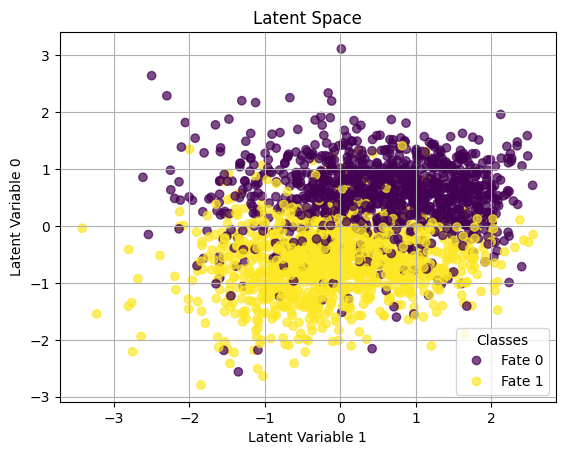

In [17]:
visualize_latent_space(encoder.predict(x_train), y_train)

In [18]:
from scipy.spatial.distance import euclidean

# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_train)[y_train == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_train)[y_train == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Distance between class centroids: 1.3359


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


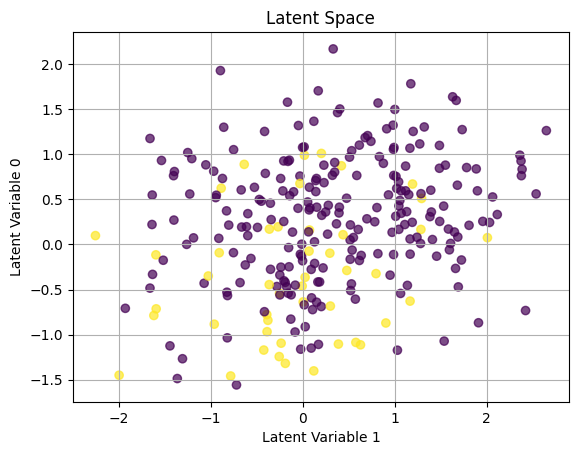

In [19]:
feat_0 = 1
feat_1 = 0
scatter = plt.scatter(encoder.predict(x_test)[:, feat_0], encoder.predict(x_test)[:, feat_1], c=y_test, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

In [20]:
from scipy.spatial.distance import euclidean

# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_test)[y_test == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_test)[y_test == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Distance between class centroids: 0.8015


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Distance between class centroids: 0.8015


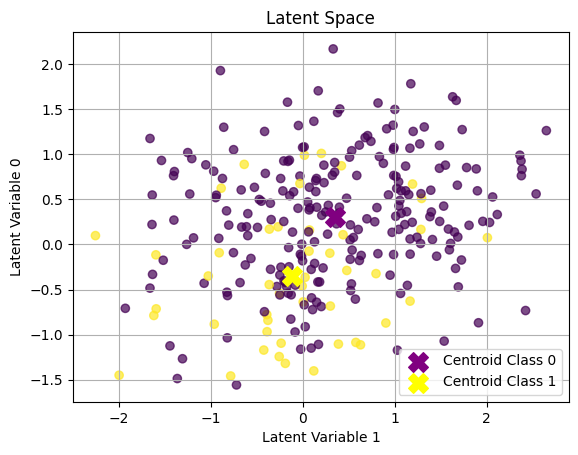

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

# Scatter plot of the latent space
feat_0 = 1
feat_1 = 0
latent_space = encoder.predict(x_test)  # Latent representation of the test set
scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_test, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

# Compute centroids for both classes
centroid_class_0 = np.mean(latent_space[y_test == 0], axis=0)
centroid_class_1 = np.mean(latent_space[y_test == 1], axis=0)

# Plot centroids
plt.scatter(centroid_class_0[feat_0], centroid_class_0[feat_1], color='purple', marker='X', s=200, label="Centroid Class 0")
plt.scatter(centroid_class_1[feat_0], centroid_class_1[feat_1], color='yellow', marker='X', s=200, label="Centroid Class 1")

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

# Display the legend
plt.legend()

# Show plot
plt.show()


In [40]:
latent_space.shape

(277, 2)

In [41]:
from scipy.stats import ttest_ind
import numpy as np

# Assuming 'latent_space' is your encoder output for the test set and 'y_test' are the labels
latent_space = encoder.predict(x_test)

# Select the two features you want to test
feat_0 = 0
feat_1 = 1

# Split latent features by class (0 and 1)
class_0_feat_0 = latent_space[y_test == 0, feat_0]
class_1_feat_0 = latent_space[y_test == 1, feat_0]

class_0_feat_1 = latent_space[y_test == 0, feat_1]
class_1_feat_1 = latent_space[y_test == 1, feat_1]

# Perform t-tests for both features
t_stat_feat_0, p_val_feat_0 = ttest_ind(class_0_feat_0, class_1_feat_0)
t_stat_feat_1, p_val_feat_1 = ttest_ind(class_0_feat_1, class_1_feat_1)

print(f"T-test for feature 0:")
print(f"T-statistic: {t_stat_feat_0}, P-value: {p_val_feat_0}")

print(f"T-test for feature 1:")
print(f"T-statistic: {t_stat_feat_1}, P-value: {p_val_feat_1}")

# Check if the p-values are smaller than a significance level (e.g., 0.05)
if p_val_feat_0 < 0.05:
    print("Feature 0 is significantly different between the classes.")
else:
    print("Feature 0 is not significantly different between the classes.")

if p_val_feat_1 < 0.05:
    print("Feature 1 is significantly different between the classes.")
else:
    print("Feature 1 is not significantly different between the classes.")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
T-test for feature 0:
T-statistic: 5.841440856923439, P-value: 1.4584473506002978e-08
T-test for feature 1:
T-statistic: 2.9320498603650975, P-value: 0.0036505575748378267
Feature 0 is significantly different between the classes.
Feature 1 is significantly different between the classes.


feature extraction from these images (both features)

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


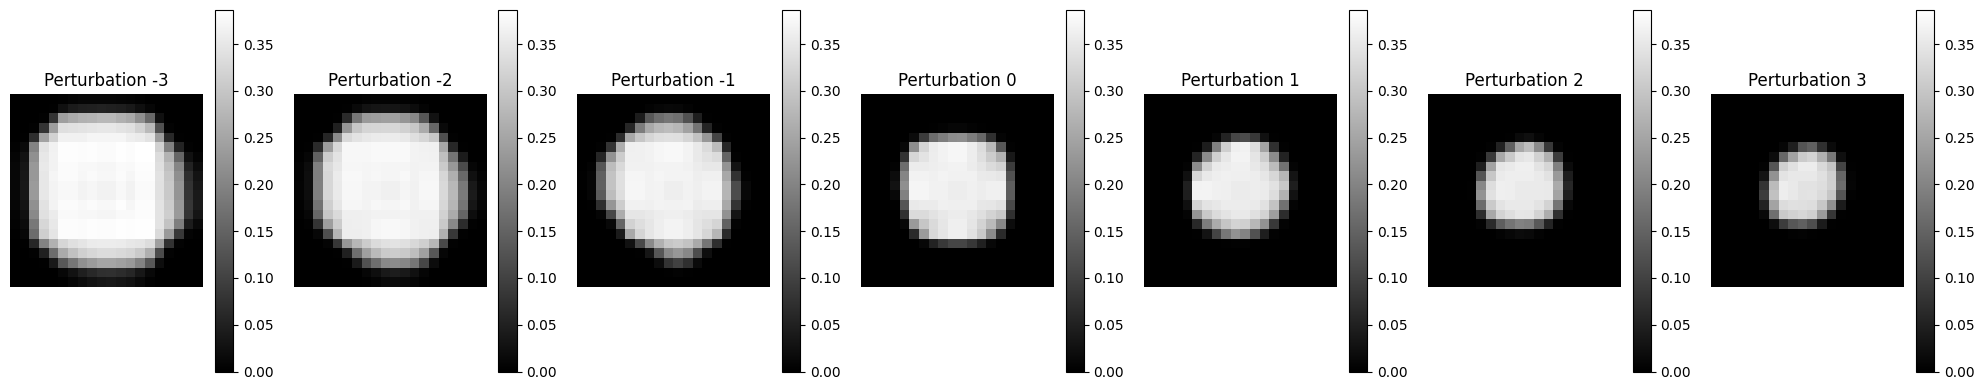

In [23]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
perturbations = [-3, -2, -1, 0, 1, 2, 3] 
#perturbations = [-0.4, -0.3, -0.1, 0, 0.1, 0.2, 0.5] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(7):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


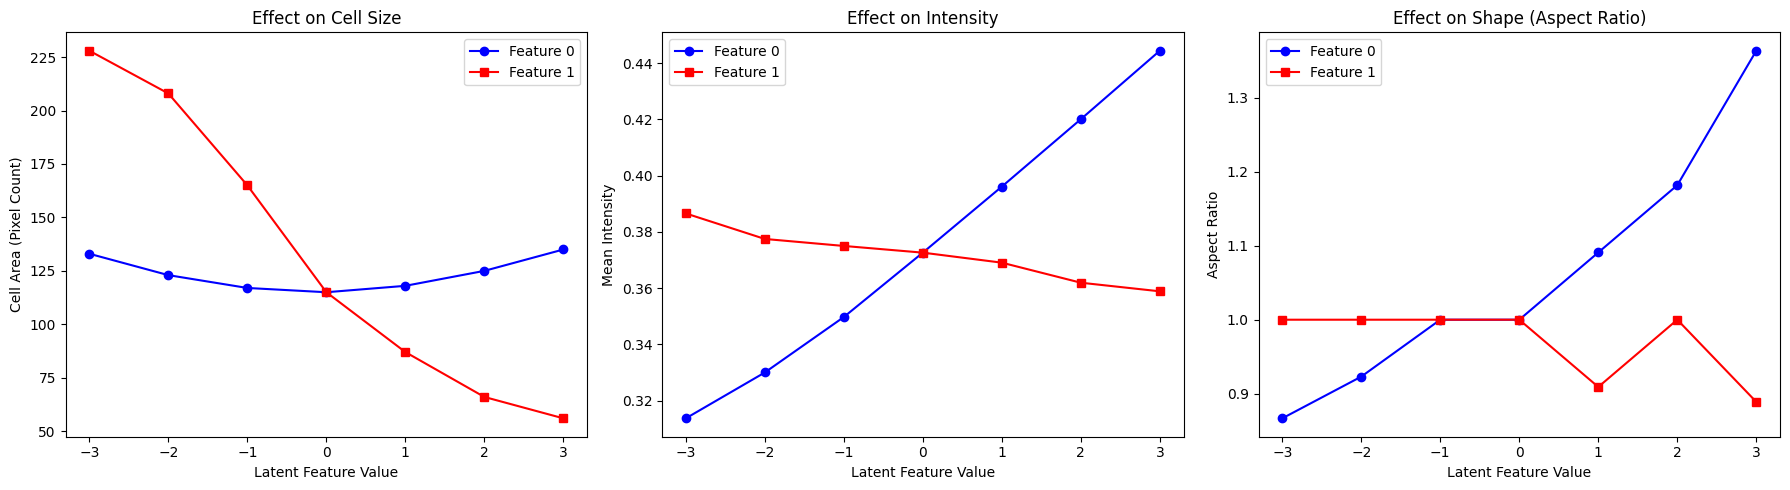

In [41]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# Function to compute mean intensity
def compute_intensity(image):
    return np.max(image)

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color='blue', label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color='red', label="Feature 1")
axs[0].set_xlabel("Latent Feature Value")
axs[0].set_ylabel("Cell Area (Pixel Count)")
axs[0].set_title("Effect on Cell Size")
axs[0].legend()

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color='blue', label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color='red', label="Feature 1")
axs[1].set_xlabel("Latent Feature Value")
axs[1].set_ylabel("Mean Intensity")
axs[1].set_title("Effect on Intensity")
axs[1].legend()

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, aspect_ratios_0, marker='o', color='blue', label="Feature 0")
axs[2].plot(perturbations, aspect_ratios_1, marker='s', color='red', label="Feature 1")
axs[2].set_xlabel("Latent Feature Value")
axs[2].set_ylabel("Aspect Ratio")
axs[2].set_title("Effect on Shape (Aspect Ratio)")
axs[2].legend()

plt.tight_layout()
plt.show()

# Checking stuff in tabular data

In [48]:
new_x_train = np.load("../data/train_images.npy")

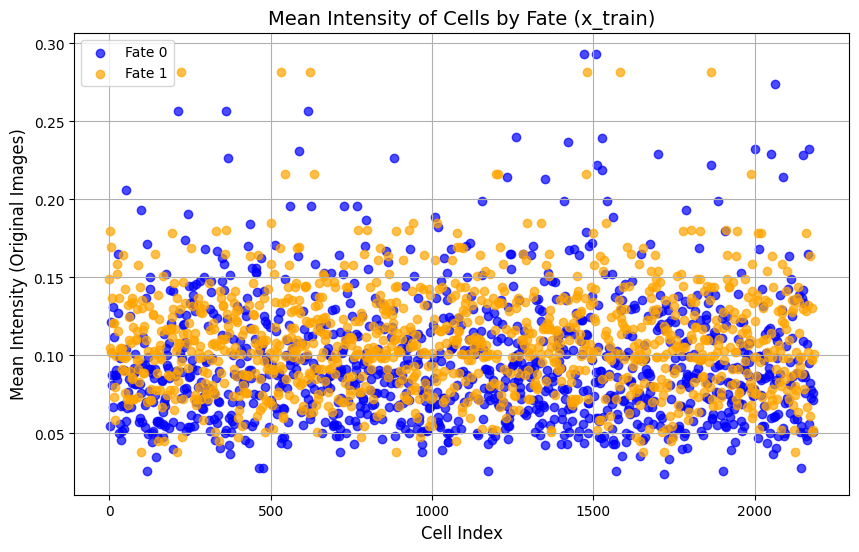

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean intensity values for x_train
mean_intensity_x_train = np.mean(x_train, axis=(1, 2))  # Average over height, width, and channels

# Separate indices by labels
fate_0_indices = np.where(y_train == 0)[0]
fate_1_indices = np.where(y_train == 1)[0]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot for fate 0
plt.scatter(
    fate_0_indices,
    mean_intensity_x_train[fate_0_indices],
    label="Fate 0",
    alpha=0.7,
    color="blue"
)

# Plot for fate 1
plt.scatter(
    fate_1_indices,
    mean_intensity_x_train[fate_1_indices],
    label="Fate 1",
    alpha=0.7,
    color="orange"
)

# Add labels, legend, and title
plt.xlabel("Cell Index", fontsize=12)
plt.ylabel("Mean Intensity (Original Images)", fontsize=12)
plt.title("Mean Intensity of Cells by Fate (x_train)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


## Tracks data

In [8]:
tracks = np.load("../data/filtered_tracks.npy")
y_train_tracks = np.load("../data/filteresd_y_train.npy")
print(tracks.shape)

(1385, 10)


In [40]:
x_train_tracks = tracks[:,[1,2,4,5,6,7]]

In [41]:
indexes_with_no_fret = np.where(x_train_tracks[:,0] == 0.0)

In [42]:
new_x_train_tracks = np.delete(x_train_tracks, indexes_with_no_fret, axis=0)
new_y_train_tracks = np.delete(y_train_tracks, indexes_with_no_fret, axis=0)

In [43]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(y_train_tracks)),
        test_size=0.2,
        stratify=y_train_tracks,
        random_state=42
    )

train_tracks = x_train_tracks[train_indexes]
test_tracks = x_train_tracks[test_indexes]
y_train_track_ = y_train_tracks[train_indexes]
y_test_track_ = y_train_tracks[test_indexes]

In [35]:
y_test_track_.shape

(277,)

In [48]:
y_test.shape

(277,)

In [44]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow.keras.regularizers import l2

def mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        #layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)), #
        #layers.Dropout(0.3),
       # layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
       # layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

In [45]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tracks.flatten()), y=y_train_tracks.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=x_train_tracks.shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks, y_test_track_, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks, y_train_track_, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_13          │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (152.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 12 (48.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4989 - loss: 0.9607 - val_accuracy: 0.7826 - val_loss: 0.5224
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.5080 - loss: 0.9541 - val_accuracy: 0.7609 - val_loss: 0.5593
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.4826 - loss: 0.9150 - val_accuracy: 0.6957 - val_loss: 0.6052
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.5149 - loss: 0.8687 - val_accuracy: 0.6377 - val_loss: 0.6419
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5055 - loss: 0.8436 - val_accuracy: 0.5652 - val_loss: 0.6672
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.5280 - loss: 0.7941 - val_accuracy: 0.5507 - val_loss: 0.6814
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5201 - loss: 0.7588 - val_accuracy: 0.5290 - val_loss: 0.6935
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5229 - loss: 0.7738 - val_accuracy: 0.52

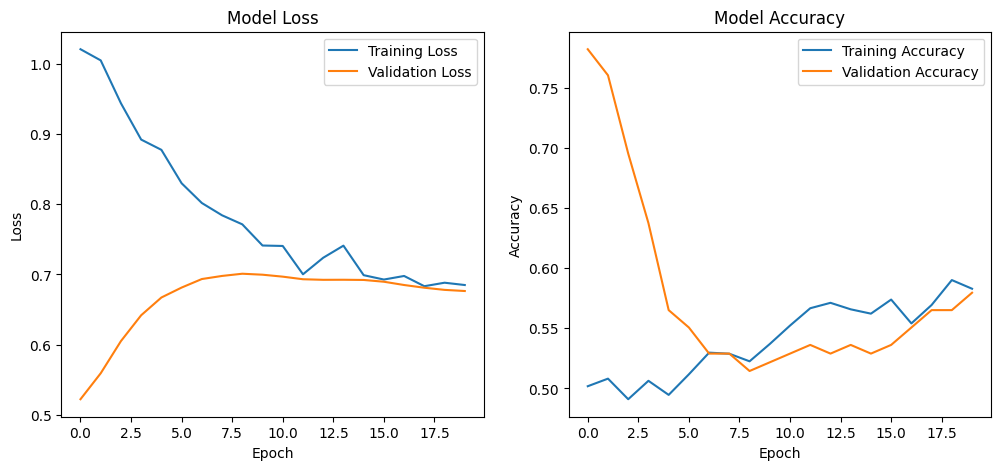

In [46]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.61261261 0.38738739]
 [0.5        0.5       ]]


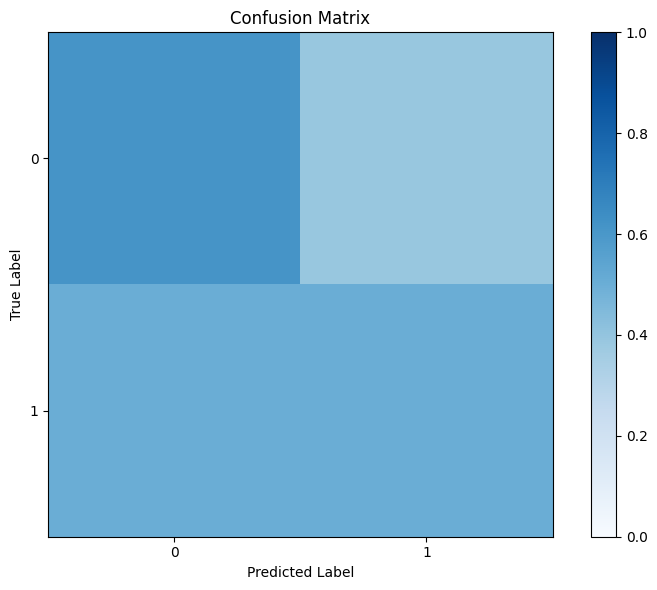

In [47]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [20]:
x_train_tracks[:,1]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

Text(0, 0.5, 'Feature 2')

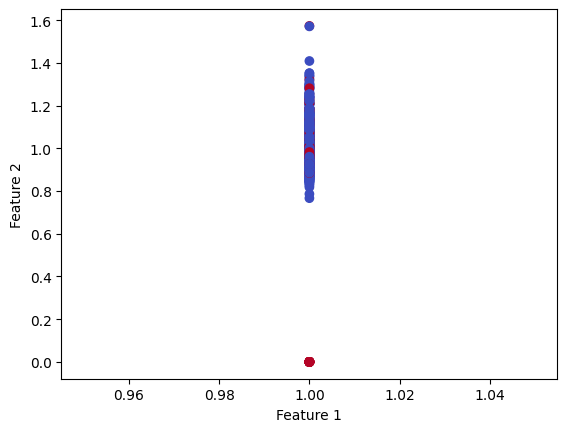

In [18]:
plt.scatter(x_train_tracks[:,1], x_train_tracks[:,2], c=y_train_tracks, cmap='coolwarm')
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2')

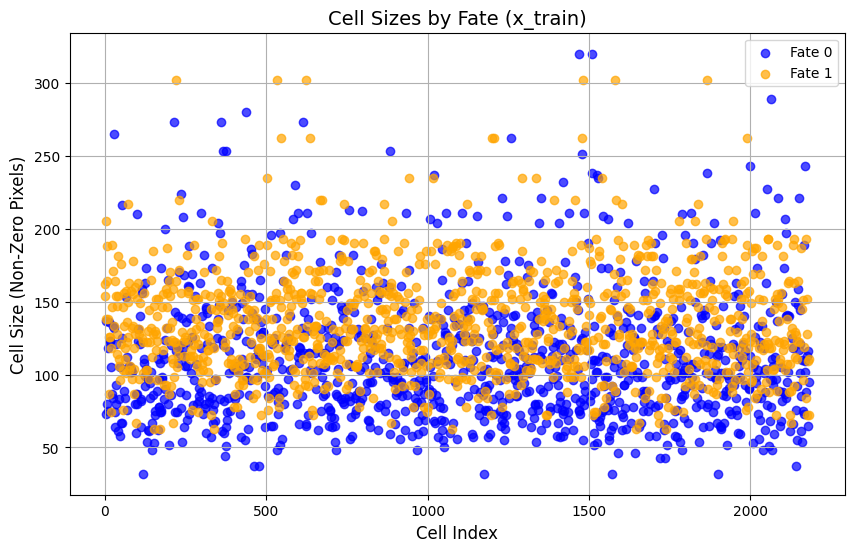

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate cell sizes (number of non-zero pixels per cell)
cell_sizes = np.sum(new_x_train > 0, axis=(1, 2))  # Sum non-zero pixels across height and width

# Separate indices by labels
fate_0_indices = np.where(y_train == 0)[0]
fate_1_indices = np.where(y_train == 1)[0]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot for fate 0
plt.scatter(
    fate_0_indices,
    cell_sizes[fate_0_indices],
    label="Fate 0",
    alpha=0.7,
    color="blue"
)

# Plot for fate 1
plt.scatter(
    fate_1_indices,
    cell_sizes[fate_1_indices],
    label="Fate 1",
    alpha=0.7,
    color="orange"
)

# Add labels, legend, and title
plt.xlabel("Cell Index", fontsize=12)
plt.ylabel("Cell Size (Non-Zero Pixels)", fontsize=12)
plt.title("Cell Sizes by Fate (x_train)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


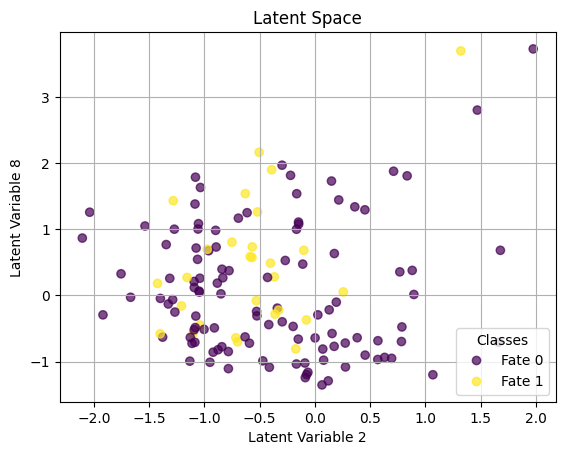

In [42]:
feat_0 = 2
feat_1 = 8
latent_space = encoder.predict(x_train)[0]
scatter = plt.scatter(x_test_[:, feat_0], x_test_[:, feat_1], c=y_test_, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

# Add legend
handles, _ = scatter.legend_elements()
plt.legend(handles, ['Fate 0', 'Fate 1'], title="Classes", loc="lower right")